# Demo for NIRISS spectral extraction

Procedure for processing a set of imaging and slitless spectroscopy observations, as of December 2023.

See other data products and description at the DAWN JWST Archive (DJA): https://dawn-cph.github.io/dja/.

In [31]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import astropy.io.fits as pyfits
import astropy.wcs as pywcs

import drizzlepac

from grizli import utils, multifit
from grizli.pipeline import auto_script
from grizli.aws import visit_processor

import grizli
print('\n grizli version: ', grizli.__version__)

import warnings
warnings.filterwarnings('ignore')

# os.chdir('/usr/local/share/python/grizli-notebooks/JWST')
HOME = os.getcwd()


 grizli version:  1.9.13.dev29+ga570fed.d20231207


# Find a grizli/DJA association that overlaps with a particular position

There is a database with a set custom defined *associations* of JWST data from many different programs.  These are not necessarily the same as the associations defined by STScI, but they can roughly be defined here as a set of exposures taken with a particular `instrument + detector + filter` combination at a particular epoch, i.e., within a single slew to the target.  *For WFSS, the associations should include both the direct and grism exposures.*

There is some limited API functionality at https://grizli-cutout.herokuapp.com for querying these associations, which is the easiest way to to run the preprocessing script in `grizli.aws.visit_processor.process_visit`, which is itself a wrapper around `grizli.pipeline.auto_script` but that also parses the assocations.

*Processing data that isn't already defined in a grizli association isn't currently supported by this notebook, but many programs should already be ingested....*

In [2]:
## SMACS 0723 ERO field
ra, dec = 110.8258712, -73.4562154 

sep = 1 # search radius, arcmin

QUERY_URL = "https://grizli-cutout.herokuapp.com/assoc?coord={ra},{dec}&arcmin={sep}&output=csv"

assoc_query = utils.read_catalog(QUERY_URL.format(ra=ra, dec=dec, sep=sep), format='csv')

nis = assoc_query['instrument_name'] == 'NIRISS'
print(assoc_query['assoc_name','target','proposal_id','filter','instrument_name','status'][nis])


                        assoc_name                              target       proposal_id    filter    instrument_name status
--------------------------------------------------------- ------------------ ----------- ------------ --------------- ------
j072304m7328_smacs-j0723.3-7327-f115w-gr150c-gr150r_00034 SMACS-J0723.3-7327        2736 GR150R-F115W          NIRISS      2
j072304m7328_smacs-j0723.3-7327-f200w-gr150c-gr150r_00037 SMACS-J0723.3-7327        2736 GR150R-F200W          NIRISS      2


## Association data

Each association has attached metadata, primarily including the names of the exposure files included in the association that can be downloaded directly from mast (e.g., with `mastquery.utils.download_from_mast`).  This metadata itself is generated from a quer with `mastquery.jwst.query_jwst` that uses the `astroquery` MAST interface.

In [3]:
assoc_info = utils.read_catalog(f"https://grizli-cutout.herokuapp.com/assoc_json?name={assoc_query['assoc_name'][nis][0]}",
                                format='pandas.json')

print(assoc_info['dataURL','proposal_id','filter','t_min','t_obs_release','status'])

                         dataURL                          proposal_id    filter         t_min       t_obs_release status
--------------------------------------------------------- ----------- ------------ ---------------- ------------- ------
mast:JWST/product/jw02736003001_02104_00006_nis_rate.fits        2736 GR150C-F115W 59747.3969072869     59773.625      2
mast:JWST/product/jw02736003001_02105_00003_nis_rate.fits        2736  CLEAR-F115W 59747.4164270895     59773.625      2
mast:JWST/product/jw02736003001_02104_00008_nis_rate.fits        2736 GR150C-F115W 59747.4068272754     59773.625      2
mast:JWST/product/jw02736003001_02105_00001_nis_rate.fits        2736  CLEAR-F115W 59747.4119937677     59773.625      2
mast:JWST/product/jw02736003001_02105_00002_nis_rate.fits        2736  CLEAR-F115W 59747.4142108048     59773.625      2
mast:JWST/product/jw02736003001_02101_00001_nis_rate.fits        2736  CLEAR-F115W 59747.3205812677     59773.625      2
mast:JWST/product/jw02736003001_

## Associations that have already been reduced

Grizli associations with `status=2` in the database have already been run through the preprocessing steps and in principle the reduced exposures can just be downloaded from the grizli AWS S3 buckets.  It is these files that are combined into the public grizli/DJA mosaics, e.g., at https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/index.html.

While this functionality isn't yet fully enabled for users without the grizli db credentials, the example below shows how to query the grizli exposure db table and download a single exposure.

The API at [https://grizli-cutout.herokuapp.com/exposures](https://grizli-cutout.herokuapp.com/exposures?help=True) will return a list of grizli/DJA-processed exposures based on various queries described at that link.  

In [4]:
EXPOSURE_API = "https://grizli-cutout.herokuapp.com/exposures?associations="
EXPOSURE_API += ','.join(assoc_query['assoc_name'][nis].tolist())

exp = utils.read_catalog(EXPOSURE_API, format='csv')

print(exp['assoc','dataset', 'extension', 'instrume', 'filter'])

                          assoc                                      dataset            extension instrume    filter   
--------------------------------------------------------- ----------------------------- --------- -------- ------------
j072304m7328_smacs-j0723.3-7327-f200w-gr150c-gr150r_00037 jw02736003001_02107_00001_nis      rate   NIRISS  F200W-CLEAR
j072304m7328_smacs-j0723.3-7327-f200w-gr150c-gr150r_00037 jw02736003001_02109_00001_nis      rate   NIRISS  F200W-CLEAR
j072304m7328_smacs-j0723.3-7327-f200w-gr150c-gr150r_00037 jw02736003001_02109_00002_nis      rate   NIRISS  F200W-CLEAR
j072304m7328_smacs-j0723.3-7327-f200w-gr150c-gr150r_00037 jw02736003001_02109_00003_nis      rate   NIRISS  F200W-CLEAR
j072304m7328_smacs-j0723.3-7327-f200w-gr150c-gr150r_00037 jw02736003001_02109_00004_nis      rate   NIRISS  F200W-CLEAR
j072304m7328_smacs-j0723.3-7327-f200w-gr150c-gr150r_00037 jw02736003001_0210b_00001_nis      rate   NIRISS  F200W-CLEAR
j072304m7328_smacs-j0723.3-7327-f200w-gr

In [5]:
# The exposure API can make an exposure map figure!
from IPython.display import Markdown as md
md(f"![exposure figure]({EXPOSURE_API}&output=figure)")

![exposure figure](https://grizli-cutout.herokuapp.com/exposures?associations=j072304m7328_smacs-j0723.3-7327-f115w-gr150c-gr150r_00034,j072304m7328_smacs-j0723.3-7327-f200w-gr150c-gr150r_00037&output=figure)

In [6]:
# Open / download a file from the public grizli AWS S3 bucket
GRIZLI_S3_URL = "https://s3.amazonaws.com/grizli-v2/HST/Pipeline/{assoc}/Prep/{dataset}_{extension}.fits"

if len(exp) > 0:
    im = pyfits.open(GRIZLI_S3_URL.format(**exp[0]))
    im.info()

Filename: /Users/gbrammer/.astropy/cache/download/url/0ab4a6d6973ecb3b15af8dbcb1672cab/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     270   ()      
  1  SCI           1 ImageHDU       207   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int16   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  TIME          1 ImageHDU        11   ()      
  9  ASDF          1 BinTableHDU     11   1R x 1C   [25944B]   


# Do the preprocessing steps

Now run the preprocessing from scratch for the example associations queried above, which will start by downloading the `rate.fits` exposures from MAST and ends with a directory that contains astrometrically-aligned, background-subtracted, calibrated exposure files.  It is exactly this script that is used for all of the DJA data processing of public HST and JWST data.  The only difference being that without write access to the grizli S3 buckets and database, we run with `sync=False, with_db=False` to do all of the processing locally.  

Note that these scripts should work for data still with a proprietary access rights if your MAST account has access to the data and you have set the `$MAST_TOKEN` environment variable appropriately.

The step below takes a while to run the first time....

In [7]:
for assoc in assoc_query['assoc_name'][nis]:
    if not os.path.exists(assoc):
        _ = visit_processor.process_visit(assoc, clean=False, sync=False, with_db=False)
    else:
        print(f'Directory {assoc} found, local preprocesing complete!')

Directory j072304m7328_smacs-j0723.3-7327-f115w-gr150c-gr150r_00034 found, local preprocesing complete!
Directory j072304m7328_smacs-j0723.3-7327-f200w-gr150c-gr150r_00037 found, local preprocesing complete!


In [8]:
# Tweakshifts refinement log
! cat {assoc}/Prep/*shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['jw02736003001_02107_00001_nis_rate.fits'] = ['jw02736003001_02108_00001_nis_rate.fits']
# match['jw02736003001_02109_00001_nis_rate.fits'] = ['jw02736003001_02108_00008_nis_rate.fits']
# match['jw02736003001_02109_00002_nis_rate.fits'] = ['jw02736003001_02108_00006_nis_rate.fits']
# match['jw02736003001_02109_00003_nis_rate.fits'] = ['jw02736003001_02108_00007_nis_rate.fits']
# match['jw02736003001_02109_00004_nis_rate.fits'] = []
# match['jw02736003001_0210b_00001_nis_rate.fits'] = []
# match['jw02736003001_0210b_00002_nis_rate.fits'] = []
# match['jw02736003001_0210b_00003_nis_rate.fits'] = []
jw02736003001_02107_00001_nis_rate.fits  -0.007   0.029  0.00000  1.00000    40  0.010  0.010
jw02736003001_02109_00001_nis_rate.fits  -0.002   0.025  0.00000  1.00000    43  0.008  0.007
jw02736003001_02109_00002_nis_rate.fits  -0.002   0.032  0.00000  1.00000    46  0.008  0.013
jw02736003001_02109_00003_nis_rate.fits  -0.012 

In [9]:
# Global astrometric alignment log
# 0 xshift yshift rotation scale rms n_ref_sources
! cat {assoc}/Prep/*wcs.log

# ext xshift yshift rot scale rms N
# radec: smacs0723_nircam_f444w_from_vircam.radec
# smacs-j0723.3-7327-02736-003-155.0-nis-f200w-clear
    0        0.8841       -3.0356       -0.0187       1.00000         0.097  168


# Make working directory for combining across the associations just preprocessed

The associations processed above include two NIRISS blocking filters and both orthogonal grisms covering the SMACS0723 ERO field.  Now we combine them to consider all of the data together.

In [10]:
os.chdir(HOME)
root = 'smacs0723'

for sub in ['Prep','Extractions']:
    path = os.path.join(HOME, root, sub)
    if not os.path.exists(path):
        os.makedirs(path)

In [11]:
# Go to preprocessing directory
os.chdir(os.path.join(HOME,root,'Prep'))

# Symlink preprocessed exposure files here
for assoc in assoc_query['assoc_name'][nis]:
    !ln -sf ../../{assoc}/Prep/*rate.fits . 

! ls *rate.fits

jw02736003001_02101_00001_nis_rate.fits jw02736003001_02107_00001_nis_rate.fits
jw02736003001_02102_00001_nis_rate.fits jw02736003001_02108_00001_nis_rate.fits
jw02736003001_02102_00002_nis_rate.fits jw02736003001_02108_00002_nis_rate.fits
jw02736003001_02102_00003_nis_rate.fits jw02736003001_02108_00003_nis_rate.fits
jw02736003001_02102_00004_nis_rate.fits jw02736003001_02108_00004_nis_rate.fits
jw02736003001_02102_00005_nis_rate.fits jw02736003001_02108_00005_nis_rate.fits
jw02736003001_02102_00006_nis_rate.fits jw02736003001_02108_00006_nis_rate.fits
jw02736003001_02102_00007_nis_rate.fits jw02736003001_02108_00007_nis_rate.fits
jw02736003001_02102_00008_nis_rate.fits jw02736003001_02108_00008_nis_rate.fits
jw02736003001_02103_00001_nis_rate.fits jw02736003001_02109_00001_nis_rate.fits
jw02736003001_02103_00002_nis_rate.fits jw02736003001_02109_00002_nis_rate.fits
jw02736003001_02103_00003_nis_rate.fits jw02736003001_02109_00003_nis_rate.fits
jw02736003001_02103_00004_nis_rate.fits 

# Make combined mosaics

Drizzle the individual exposures into final mosaics

In [12]:
# Make a table with file information
files = glob.glob('*rate.fits')
files.sort()
res = visit_processor.res_query_from_local(files=files)
is_grism = np.array(['GR' in filt for filt in res['filter']])

In [13]:
# Mosaic WCS that contains the exposures, but could come from somewhere else
hdu = utils.make_maximal_wcs(files=files,
                             pixel_scale=0.04,
                             pad=4,
                             get_hdu=True, verbose=False)

ref_wcs = pywcs.WCS(hdu.header)

# Make the mosaics, e.g., ``myfield-f200wn-clear_drc_sci.fits``

_ = visit_processor.cutout_mosaic(root,
                                  res=res[~is_grism], # Pass the exposure information table for the direct images
                                  ir_wcs=ref_wcs,
                                  half_optical=False, # Otherwise will make JWST exposures at half pixel scale of ref_wcs
                                  kernel='square', # Drizzle parameters
                                  pixfrac=0.8,
                                  clean_flt=False, # Otherwise removes "rate.fits" files from the workign directory!
                                  s3output=None,
                                  make_exptime_map=False,
                                  weight_type='jwst',
                                  skip_existing=True,
                                 )


Fix NIRISS: filters = F115WN-CLEAR F200WN-CLEAR
Skip smacs0723-f115wn-clear
Skip smacs0723-f200wn-clear


In [14]:
! ls -1 {root}*_dr*fits

smacs0723-f115wn-clear_drc_sci.fits
smacs0723-f115wn-clear_drc_wht.fits
smacs0723-f200wn-clear_drc_sci.fits
smacs0723-f200wn-clear_drc_wht.fits


# Make source catalog

Run the SourceExtractor clone `sep` on one of the mosaics to make a source catalog.  The segmentation image and catalog can also come from somewhere else, e.g., from detecting on a deep NIRCam image, as long as it is astrometrically aligned to the exposures you want to process here.

In [16]:
from grizli import prep

catfile = 'smacs0723-ir.cat.fits'
if not os.path.exists(catfile):
    _cat = prep.make_SEP_catalog('smacs0723-f200wn-clear', threshold=1.2)
    
    # Script below needs to find catalog named like {root}-ir.cat.fits
    # so just make a symlink here
    ! ln -sf smacs0723-f200wn-clear_seg.fits smacs0723-ir_seg.fits
    ! ln -sf smacs0723-f200wn-clear.cat.fits smacs0723-ir.cat.fits
else:
    print(f'Existing catalog {catfile} found')
    

Existing catalog smacs0723-ir.cat.fits found


# Grism processing

For just imaging, you're pretty much done after the steps above.  Below are additional steps for extracting WFSS spectra.

## Initialize Grism GroupFLT objects

This step associates the direct image mosaic, segmentation image and catalog with the grism exposures and derives the contamination model, optionally refined with polynomial fits to the spectra of bright sources.

In [17]:
from grizli.pipeline import auto_script

os.chdir(os.path.join(HOME, root, 'Prep'))

pad = (1024, 1024)

# Process by blocking filter
un = utils.Unique(res['pupil'])

if len(glob.glob('*GrismFLT.fits')) == 0:
    
    grp = {}
    
    for filt in un.values:
            
        grism_files = ['{dataset}_rate.fits'.format(**row)
                       for row in res[is_grism & un[filt]]]
        
        # subset for a faster test
        grism_files = grism_files[:4]
    
        grp[filt] = auto_script.grism_prep(field_root=root,
                                 PREP_PATH='../Prep', 
                                 EXTRACT_PATH='../Extractions/', 
                                 refine_niter=2,
                                 refine_mag_limits=[16, 24], 
                                 prelim_mag_limit=26,
                                 init_coeffs=[1, -0.6],
                                 pad=pad,
                                 files=grism_files,
                                 model_kwargs={'compute_size': False, 'size':48},
                                 subtract_median_filter=False,
                                 use_jwst_crds=False,
                                )

   N  value     
====  ==========
  24  F115W     
  24  F200W     


## Load saved grism model files

You don't have to recompute the contamination models each time, but can restart the processing by loading the `GrismFLT.fits` files created in the previous step.

In [18]:
os.chdir(os.path.join(HOME, root, 'Extractions'))

un = utils.Unique(res['pupil'], verbose=False)

all_grism_files = glob.glob('*GrismFLT.fits')
all_grism_files.sort()

file_filters = {}
for f in all_grism_files:
    with pyfits.open(f) as im:
        filt = im[1].header['DFILTER'].split('-')[0]
        if filt not in file_filters:
            file_filters[filt] = []

        file_filters[filt].append(f)

filts = un.values

grism_files = []
for filt in filts:
    if filt in file_filters:
        grism_files += file_filters[filt]

catalog = glob.glob(f'{root}-*.cat.fits')[0]
seg_file = glob.glob(f'{root}-*_seg.fits')[0]

grp = {}
for filt in filts:
    if filt not in file_filters:
        continue
    
    print(filt, len(file_filters[filt]), ' '.join(file_filters[filt]))
    print('\n-------------------------\n')
    
    grp[filt] = multifit.GroupFLT(grism_files=file_filters[filt],
                                  direct_files=[], 
                                  ref_file=None, # automatically compute based on the filter
                                  seg_file=seg_file, 
                                  catalog=catalog,
                                  cpu_count=-1, sci_extn=1, 
                                  pad=1200)

F115W 4 jw02736003001_02102_00001_nis.01.GrismFLT.fits jw02736003001_02102_00002_nis.01.GrismFLT.fits jw02736003001_02102_00003_nis.01.GrismFLT.fits jw02736003001_02102_00004_nis.01.GrismFLT.fits

-------------------------

Load jw02736003001_02102_00001_nis.01.GrismFLT.fits!


Transform JWST WFSS: flip=True
Load jw02736003001_02102_00002_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Load jw02736003001_02102_00003_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Load jw02736003001_02102_00004_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Files loaded - 0.66 sec.
F200W 4 jw02736003001_02108_00001_nis.01.GrismFLT.fits jw02736003001_02108_00002_nis.01.GrismFLT.fits jw02736003001_02108_00003_nis.01.GrismFLT.fits jw02736003001_02108_00004_nis.01.GrismFLT.fits

-------------------------

Load jw02736003001_02108_00001_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Load jw02736003001_02108_00002_nis.01.GrismFLT.fits!
Transform JWST WFSS: flip=True
Load jw02736003001_02

## Drizzle combined images by grism / PA

- `*grism_sci.fits` is the combination of the raw grism exposures
- `*grism_clean.fits` is the combination of the median-filtered images

In [19]:
# Make drizzled diagnostic images of the contamination models
if 0:
    utils.set_warnings()

    for k in grp:
        grp[k].drizzle_grism_models(root=root, kernel='square', scale=0.06, pixfrac=0.75)

## Initialize redshift fit defaults

Set some defaults for the redshift fits.

In [21]:
args['dz']

[0.004, 0.0004]

In [22]:
import astropy.units as u

args = auto_script.generate_fit_params(field_root=root, 
                                       zr=[0.02, 8], # full redshift range to fit
                                       dz=[0.004, 0.0004], # two-pass redshift grid steps in (1+z)
                                       sys_err=0.03,
                                       include_photometry=False,
                                       fit_trace_shift=False, # this can help with some trace misalignment
                                       dscale=0.01,
                                       fwhm=500.*u.km/u.second, # velocity width of emission line templates
                                       full_line_list=['Lya', 'OII', 'Hb',
                                                       'OIII', 'Ha', 'NII','Ha+NII', 'SII', 'SIII',
                                                       'PaD','PaG','PaB','HeI-1083','PaA'], # Make line maps of these
                                       min_sens=1.e-6, min_mask=1.e-6, # masking around sensitivity edges
                                       mask_resid=True,
                                       fcontam=0.2, # include a contribution of the contamination model in the uncertainties
                                       pline={'kernel': 'square', 'pixfrac': 0.5, # line map parameters
                                              'pixscale': 0.05, 'size': 8, 'wcs': None},
                                )


Saved arguments to fit_args.npy.


# Extract and fit a test source

In [24]:
src = utils.read_catalog("""ra, dec, comment
110.8534944, -73.4596559, multiple lines
110.8386544, -73.4493347, line
110.8440811, -73.4442407, OIII emitter
""", format='csv')

# Find the corresponding source id
k = un.values[0]
idx, dr = grp[k].catalog.match_to_catalog_sky(src)

src['catalog_id'] = grp[k].catalog['NUMBER'][idx]
src['dr'] = dr
src['dr'].format = '.2f'

print(src)

     ra         dec        comment     catalog_id   dr  
    deg         deg                               arcsec
----------- ----------- -------------- ---------- ------
110.8534944 -73.4596559 multiple lines       1410   0.02
110.8386544 -73.4493347           line       2976   0.02
110.8440811 -73.4442407   OIII emitter       2926   0.06


In [26]:
id = src['catalog_id'][0]
size = 48

In [27]:
beams = []
mbf = {}
beam_groups = {}

for filt in grp:
    beams_i = grp[filt].get_beams(id, size=size, min_mask=args['min_mask'], min_sens=args['min_sens'], mask_resid=False)
    msg = f'{filt} {len(beams_i)}'
    beams += beams_i

mb = multifit.MultiBeam(beams, **args)
print(id, len(beams))
    
mb.write_master_fits()

for b in mb.beams:
    print(b.grism.filter, b.grism.pupil, b.beam.conf.conf_file)

1410 8
smacs0723_01410.beams.fits
GR150R F115W /Users/gbrammer/Research/grizli/CONF/GR150R.F115W.221215.conf
GR150R F115W /Users/gbrammer/Research/grizli/CONF/GR150R.F115W.221215.conf
GR150R F115W /Users/gbrammer/Research/grizli/CONF/GR150R.F115W.221215.conf
GR150R F115W /Users/gbrammer/Research/grizli/CONF/GR150R.F115W.221215.conf
GR150R F200W /Users/gbrammer/Research/grizli/CONF/GR150R.F200W.221215.conf
GR150R F200W /Users/gbrammer/Research/grizli/CONF/GR150R.F200W.221215.conf
GR150R F200W /Users/gbrammer/Research/grizli/CONF/GR150R.F200W.221215.conf
GR150R F200W /Users/gbrammer/Research/grizli/CONF/GR150R.F200W.221215.conf


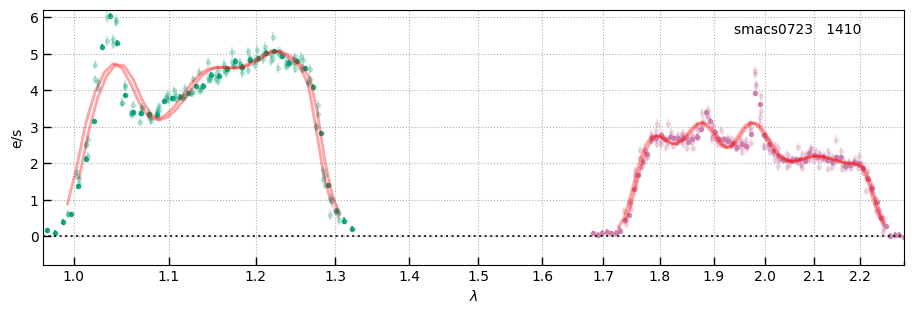

In [32]:
# Dummy fit of spline templates for an initial look at the spectra
tspl = utils.bspline_templates(wave=np.linspace(0.9, 2.3, 512)*1.e4, df=33)
tfit = mb.template_at_z(z=0, templates=tspl)

fig1 = mb.oned_figure(bin=2, tfit=tfit, show_rest=False, figsize=(9,3),
                      show_beams=True, ylim_percentile=0.1, units='eps')

In [ ]:
# Run the redshift fit
from grizli import fitting
_ = fitting.run_all_parallel(id, verbose=False,
                             get_output_data=True,
                             fit_trace_shift=True, zr=[0.1, 3.6])

Run id=1410 with fit_args.npy
